# 2D square lattice Ising model & Metropolis algorithm

## 1. Preparation - Physical quantities and measurement 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
"""
Here generate a L x L 2D square matrix
The structure of matrix is like
{index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2)}, ... }

"""

def gen_lattice_2D_square_lattice(L):
  lattice_dict={}
  N = L*L
  for i in range(N):
    temp = {"spin":np.random.choice([1,-1])}
    # Move to certain y level
    # Add x back
    x,y = i%L, i//L
    left_index = (x-1)%L + y*L
    right_index = (x+1)%L + y*L
    up_index = x + ((y-1)%L)*L
    down_index = x + ((y+1)%L)*L
    temp["neighbours"] = (left_index,right_index,up_index,down_index)
    lattice_dict[i] = temp

  return lattice_dict

In [3]:
"""
Below are the definitions of different physical quantities, including 
- (Normalized) energy
- (Normalized) magnetization
- (Normalized) specific heat
- (Normalized) susceptibility
"""

# Energy
def Energy(lattice_dict,L):
  Energy = 0
  for i in range(L*L):
    S = lattice_dict[i]['spin']

    Neighbour_sum = 0
    for j in lattice_dict[i]['neighbours']:
      Neighbour_sum+=lattice_dict[j]['spin']

    Energy += -S*Neighbour_sum
  # I divide Neighbour_sum by 2 to deal with overcounting
  return float(Energy)/2

# Absolute value of magnetization (lower case m)
def M(lattice_dict,L):
  M = 0
  for i in lattice_dict.values():
    M+=i["spin"]
  M = abs(M/(L*L))
  return M

# specific_heat
def specific_heat(L,T,Energy_list):
  N = L**2
  Energy_mean = np.mean(Energy_list)
  Energy_square_mean =np.mean(np.square(Energy_list))
  return 1/(N*T)*(Energy_square_mean - Energy_mean**2)

# susceptibility
def susceptibility(L,T,M_list):
  N = L*L
  M_list = [i*N for i in M_list]
  M_mean = np.mean(np.abs(M_list))
  M_square_mean = np.mean(np.square(M_list))
  return (M_square_mean - M_mean**2)/(N*T)

## 2. Ising Model - Metropolis algorithm

In [4]:
"""
MC step

This function will perform 1 MC step for square lattice

Parameters
----------
1. lattice_dict
 {index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2)}, ... }
2. T - temperature
3. L - the length of a square lattice
-------

Return
----------
1. lattice_dict - the flipped lattice_dict

-------

"""
def MC_step_square(lattice_dict,T,L):

  for j in range(L*L):
    index = np.random.randint(0,L*L)

    spin_at_index = lattice_dict[index]["spin"]

    Neighbour_sum = 0

    for i in lattice_dict[index]['neighbours']:
      Neighbour_sum+=lattice_dict[i]['spin']

    delta_E = 2*spin_at_index*Neighbour_sum

    if delta_E < 0 or (np.random.rand() < np.exp(-delta_E/T)):
      lattice_dict[index]['spin'] *= -1

  return lattice_dict

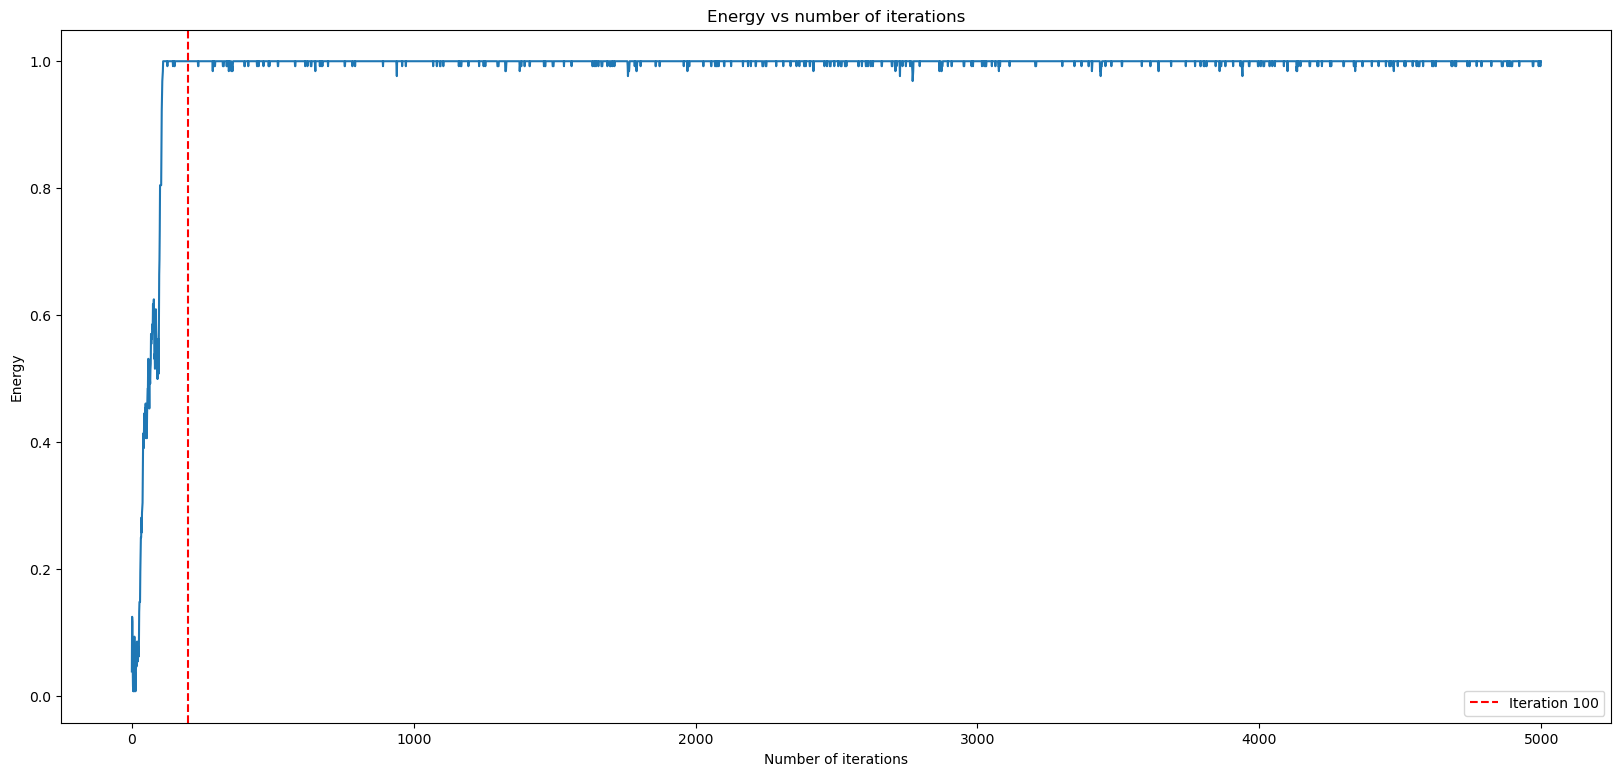

In [7]:
# Checking whether the energy values would converge over MC steps 

def checking_converge(Temperature,iteration,L):
  M_list = []
  lattice_dict = gen_lattice_2D_square_lattice(L)

  for i in range(iteration):
    lattice_dict = MC_step_square(lattice_dict,Temperature,L)
    M_list.append(M(lattice_dict,L))

  return M_list

Temperature = 1     # Temperature
Iterations = 5000   # Totoal number of iterations
L = 16              # System size 

plt.figure(figsize=(20,9))
Energy_list = checking_converge(Temperature,Iterations,L)

plt.plot([i for i in range(0,Iterations)],Energy_list)

plt.axvline(x=200, color='red', linestyle='--', label='Iteration 100')
plt.legend()

plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.title("Energy vs number of iterations")
plt.show()

As you can see from the graph above, for the 2D square Ising lattice with $L=16$, $\beta = T = 1$, the energy converges after around 100 steps of iteration. 

You can vary the system size $L$ and $\beta$, and see how these 2 quantities would affect the steps needed for thermalization. 

### Metropolis_algorithm

In [8]:
"""
Metropolis_algorithm

temp_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[]}

expect_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}

Parameters
----------
1. lattice_dict
 {index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2)}, ... }
2. T - temperature
3. L - the length of a square lattice
-------

Return
----------
1. expect_dict - it contains the mean value of (iterations num times) of  "Energy per N" ,"m^2" ,"|m|" ,"specific heat" ,"suspectility"
                  at a particular temperature
It has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}

2.sd_dict - it contains the standard deviation of (iterations num times) of  "Energy per N" ,"m^2" ,"|m|" ,"specific heat" ,"suspectility"
                  at a particular temperature
It has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}
-------

"""

def metropolis_algo_at_T(Temperature,iteration,L):

#1. Generate equilibrium lattice
  lattice_dict = gen_lattice_2D_square_lattice(L)
  for i in range(4000):                                        # thermialization steps. 4000 steps is enough to reach equilibrium (check last section)
    lattice_dict = MC_step_square(lattice_dict,Temperature,L)

 #2. Keep on running,collect data
  expect_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
  sd_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
  temp_dict={"Energy per N":[],"Absolute M":[],"Energy":[],"M^2":[]}

  for i in range(iteration):
    lattice_dict = MC_step_square(lattice_dict,Temperature,L)
    temp_dict["Energy"].append(Energy(lattice_dict,L))
    temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(M(lattice_dict,L))
    temp_dict["M^2"].append(M(lattice_dict,L)**2)


    if i%100==0 and i!=0:
      expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))

      expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  ## Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at temperature = {:.2f}".format(Temperature))

  return expect_dict,sd_dict

In [9]:
L = 10                      # system size 
iteration = 1000            
T = np.linspace(0.25,4,16)

final_mean_dict_mc = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
final_sd_dict_mc = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
for i in range(0,len(T)):

    expect_dict, sd_dict = metropolis_algo_at_T(T[i],iteration,L)

    for i in expect_dict.keys():
      final_mean_dict_mc[i].append(float(expect_dict[i]))
      final_sd_dict_mc[i].append(float(sd_dict[i]))


Complete collecting data at temperature = 0.25
Complete collecting data at temperature = 0.50
Complete collecting data at temperature = 0.75
Complete collecting data at temperature = 1.00
Complete collecting data at temperature = 1.25
Complete collecting data at temperature = 1.50
Complete collecting data at temperature = 1.75
Complete collecting data at temperature = 2.00
Complete collecting data at temperature = 2.25
Complete collecting data at temperature = 2.50
Complete collecting data at temperature = 2.75
Complete collecting data at temperature = 3.00
Complete collecting data at temperature = 3.25
Complete collecting data at temperature = 3.50
Complete collecting data at temperature = 3.75
Complete collecting data at temperature = 4.00


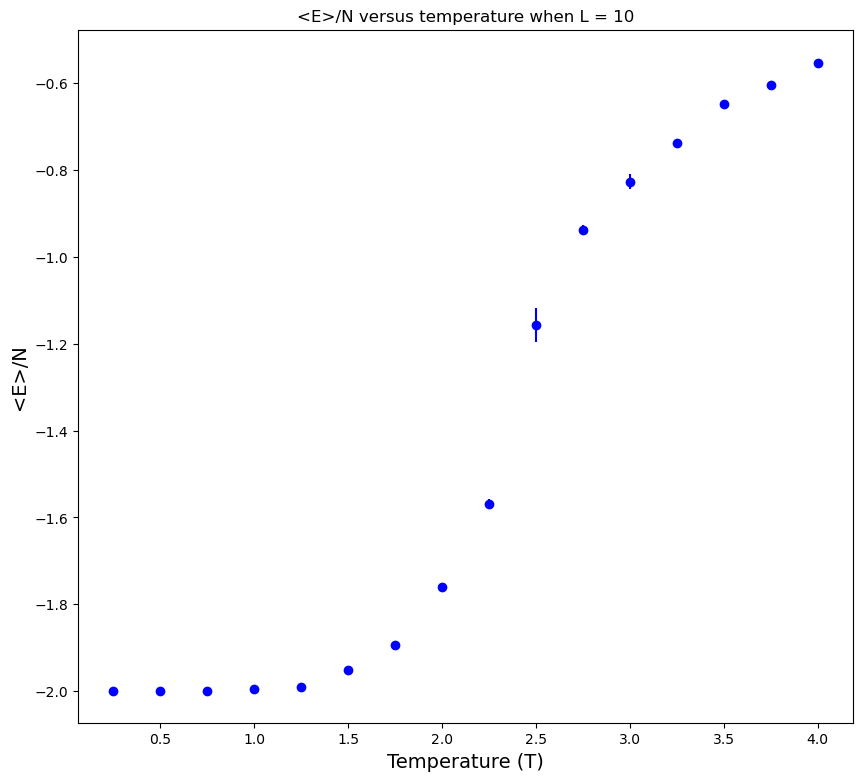

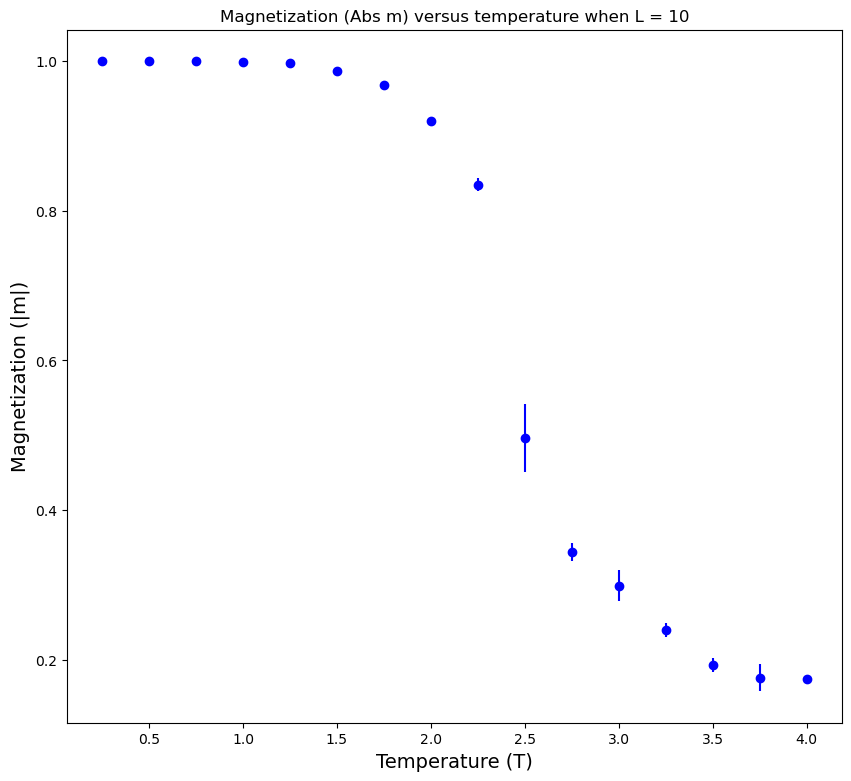

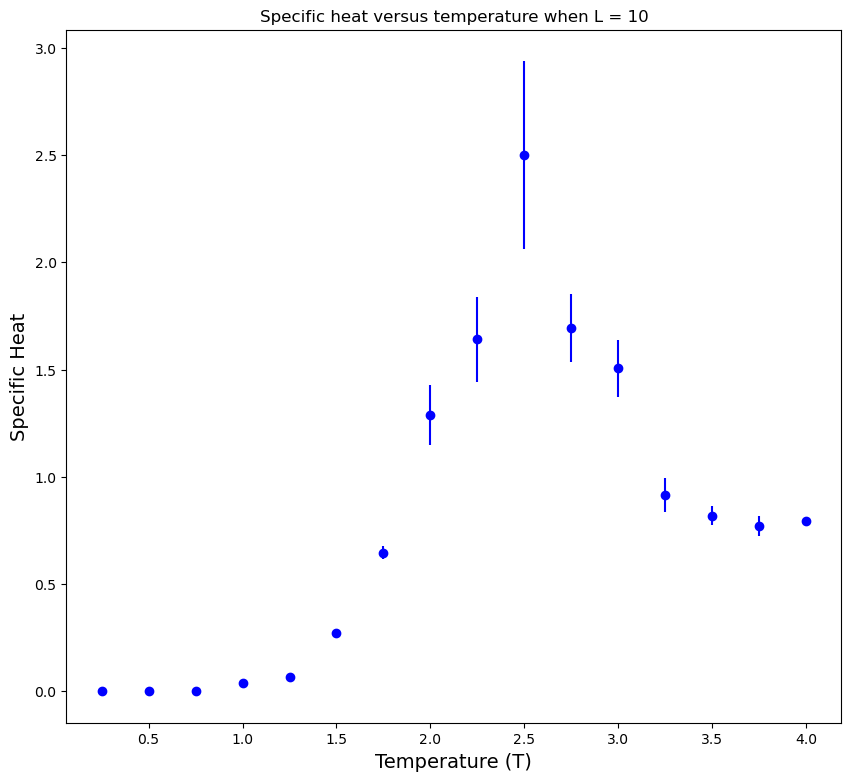

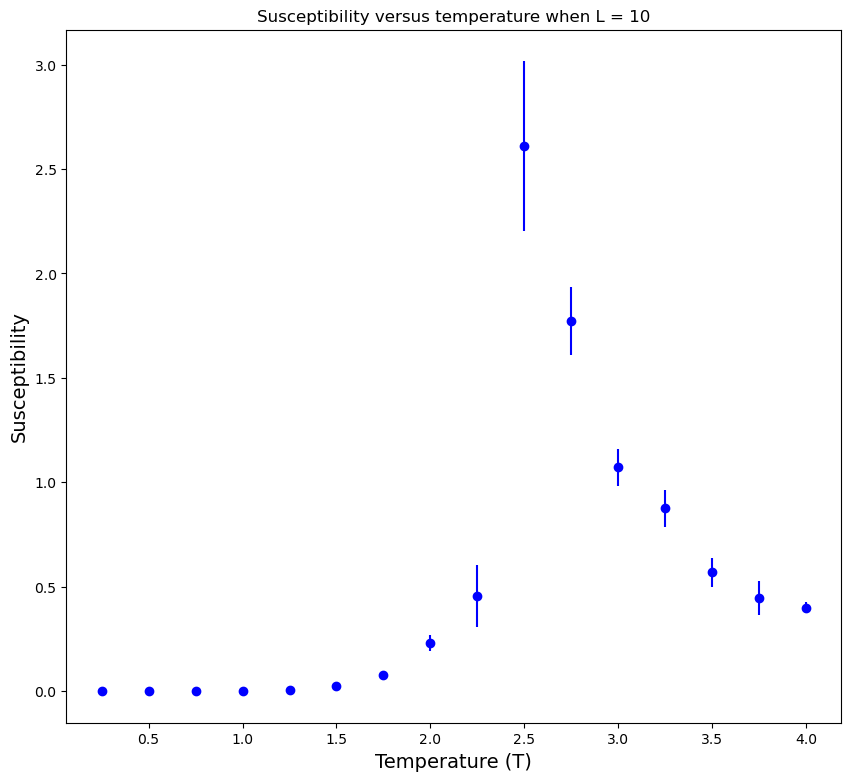

In [ ]:
# <E>/N
plt.figure(figsize=(10,9))
plt.errorbar(T, final_mean_dict_mc["Energy per N"], final_sd_dict_mc["Energy per N"], fmt='o', color="blue")
plt.title("Energy versus temperature when L = {l}".format(l=L))
plt.xlabel("Temperature (T)", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.show()

# Absolute m
plt.figure(figsize=(10,9))
plt.errorbar(T, final_mean_dict_mc["Absolute M"], final_sd_dict_mc["Absolute M"], fmt='o', color="blue")
plt.title("Magnetization (Abs m) versus temperature when L = {l}".format(l=L))
plt.xlabel("Temperature (T)", fontsize=14)
plt.ylabel("Magnetization (|m|)", fontsize=14)
plt.show()

# Specific heat
plt.figure(figsize=(10,9))
plt.errorbar(T, final_mean_dict_mc["specific heat"], final_sd_dict_mc["specific heat"], fmt='o', color="blue")
plt.title("Specific heat versus temperature when L = {l}".format(l=L))
plt.xlabel("Temperature (T)", fontsize=14)
plt.ylabel("Specific Heat", fontsize=14)
plt.show()

# Susceptibility
plt.figure(figsize=(10,9))
plt.errorbar(T, final_mean_dict_mc["suspectility"], final_sd_dict_mc["suspectility"], fmt='o', color="blue")
plt.title("Susceptibility versus temperature when L = {l}".format(l=L))
plt.xlabel("Temperature (T)", fontsize=14)
plt.ylabel("Susceptibility", fontsize=14)
plt.show()
